# Overview

This notebook compares spatial distributions of TF-IDF scores and sentiments, and their changes over time. 

# Spatial TF-IDF distributions 

In [ ]:
# import libraries
import psycopg2
import geopandas as gpd
import pandas as pd
import geoplot.crs as gcrs
import geoplot as gplt
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pysal as ps
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
import seaborn as sns

## Absolute differences

In [28]:
conn=psycopg2.connect("")
gdf = gpd.GeoDataFrame.from_postgis("select * from london_msoa_2011_gen_4326", conn, geom_col='geom')
conn.close()

# load overall Flickr scores for MSOAs
flickr_global_top5 = pd.read_csv('flickr_global_overall_top5_scores.csv')
flickr_local_top5 = pd.read_csv('flickr_local_overall_top5_scores.csv')

gf_gdf = pd.merge(gdf, flickr_global_top5, left_on='code', right_on='MSOA')
lf_gdf = pd.merge(gdf, flickr_local_top5, left_on='code', right_on='MSOA')

# load overall Twitter scores for MSOAs
twitter_global_top5 = pd.read_csv('twitter_global_overall_top5_scores.csv')
twitter_local_top5 = pd.read_csv('twitter_local_overall_top5_scores.csv')

gt_gdf = pd.merge(gdf, twitter_global_top5, left_on='code', right_on='MSOA')
lt_gdf = pd.merge(gdf, twitter_local_top5, left_on='code', right_on='MSOA')

# compare 'park' at global and local levels between Flickr and Twitter
# all percentages as difference of Flickr from Twitter
# i.e. positive means Flickr scored that many percentage points higher than Twitter,
# and negative means Flickr scored that many percentage points lower than Twitter
gdf['park_gl_diff'] = gf_gdf['park'] - gt_gdf['park']
gdf['park_gl_diff_perc'] = (gf_gdf['park'] - gt_gdf['park'])/gt_gdf['park']*100
gdf['park_lo_diff'] = lf_gdf['park'] - lt_gdf['park']
gdf['park_lo_diff_perc'] = (lf_gdf['park'] - lt_gdf['park'])/lt_gdf['park']*100

# compare 'road' at global and local levels between Flickr and Twitter
gdf['road_gl_diff'] = gf_gdf['road'] - gt_gdf['road']
gdf['road_gl_diff_perc'] = (gf_gdf['road'] - gt_gdf['road'])/gt_gdf['road']*100
gdf['road_lo_diff'] = lf_gdf['road'] - lt_gdf['road']
gdf['road_lo_diff_perc'] = (lf_gdf['road'] - lt_gdf['road'])/lt_gdf['road']*100

gdf.head()

,gid,code,name,label,geom,neighbors,park_gl_diff,park_gl_diff_perc,park_lo_diff,park_lo_diff_perc,road_gl_diff,road_gl_diff_perc,road_lo_diff,road_lo_diff_perc
0,229,E02000235,Croydon 042,E09000008E02000235,"MULTIPOLYGON (((-0.09792 51.33948, -0.09632 51...","{E02000228,E02000230,E02000232,E02000233,E0200...",0.001547,8.824187,0.005195,30.211400,0.025129,inf,0.025867,inf
1,821,E02000851,Sutton 012,E09000029E02000851,"MULTIPOLYGON (((-0.19221 51.37422, -0.19207 51...","{E02000846,E02000852,E02000853,E02000854,E0200...",0.046581,162.821382,0.049951,166.980317,0.046987,1037.468993,0.051339,1267.239084
2,820,E02000850,Sutton 011,E09000029E02000850,"MULTIPOLYGON (((-0.13300 51.39031, -0.13273 51...","{E02000209,E02000212,E02000217,E02000221,E0200...",0.651057,1579.142943,0.641072,1519.354422,0.048570,366.362036,0.048586,368.477442
3,825,E02000855,Sutton 016,E09000029E02000855,"MULTIPOLYGON (((-0.22811 51.36857, -0.22781 51...","{E02000847,E02000848,E02000853,E02000857,E0200...",-0.039727,-18.396659,-0.035622,-16.960771,0.038719,121.970040,0.035963,103.853638
4,819,E02000849,Sutton 010,E09000029E02000849,"MULTIPOLYGON (((-0.15109 51.37415, -0.15108 51...","{E02000843,E02000850,E02000854,E02000856}",0.510350,158.913009,0.544681,170.395187,0.003248,12.779040,0.005578,22.683097


0.9654402522996937


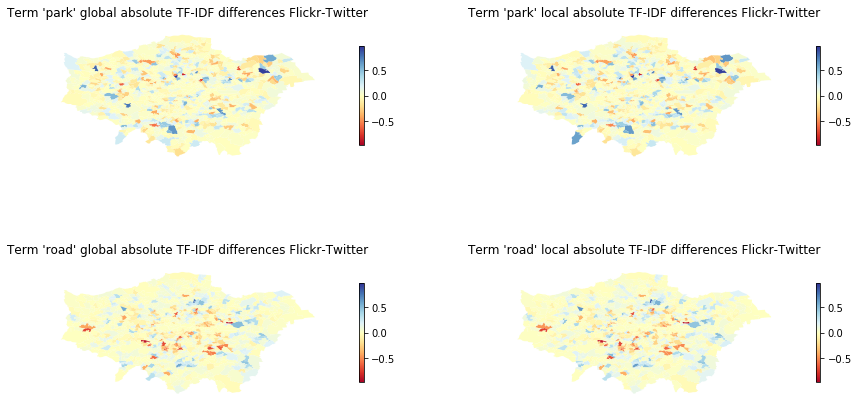

In [29]:
# Plot absolute differences in TF-IDF
fig, axarr = plt.subplots(2, 2, figsize=(15, 8))

max_value = abs(max([max(gdf['park_gl_diff']), max(gdf['park_lo_diff']), max(gdf['road_gl_diff']), max(gdf['road_lo_diff'])]))
print(max_value)

gplt.choropleth(gdf,
                ax=axarr[0][0],
                hue='park_gl_diff',
                cmap='RdYlBu',
                linewidth=0.0,
                norm=colors.Normalize(vmin=-max_value, vmax=max_value),
                legend=True,
                legend_kwargs={'shrink': 0.5})
axarr[0][0].set_title("Term 'park' global absolute TF-IDF differences Flickr-Twitter")

gplt.choropleth(gdf,
                ax=axarr[0][1],
                hue='park_lo_diff',
                cmap='RdYlBu',
                linewidth=0.0,
                norm=colors.Normalize(vmin=-max_value, vmax=max_value),
                legend=True,
                legend_kwargs={'shrink': 0.5})
axarr[0][1].set_title("Term 'park' local absolute TF-IDF differences Flickr-Twitter")

gplt.choropleth(gdf,
                ax=axarr[1][0],
                hue='road_gl_diff',
                cmap='RdYlBu',
                linewidth=0.0,
                norm=colors.Normalize(vmin=-max_value, vmax=max_value),
                legend=True,
                legend_kwargs={'shrink': 0.5})
axarr[1][0].set_title("Term 'road' global absolute TF-IDF differences Flickr-Twitter")
                               
gplt.choropleth(gdf,
                ax=axarr[1][1],
                hue='road_lo_diff',
                cmap='RdYlBu',
                linewidth=0.0,
                norm=colors.Normalize(vmin=-max_value, vmax=max_value),
                legend=True,
                legend_kwargs={'shrink': 0.5})
axarr[1][1].set_title("Term 'road' local absolute TF-IDF differences Flickr-Twitter")

plt.show()

## Spatial Clustering of differences

In [30]:
# create spatial weights
gdf = gdf.rename(columns={"geom": "geometry"})
nW = ps.lib.weights.Queen.from_dataframe(gdf, idVariable='code')
nW.transform = 'r'

In [31]:
# global Moran's I
gmoran = ps.explore.esda.Moran(gdf['park_gl_diff'], nW)
print('park_gl_diff: ', round(gmoran.I, 3), gmoran.p_sim)
gmoran = ps.explore.esda.Moran(gdf['park_lo_diff'], nW)
print('park_lo_diff: ', round(gmoran.I, 3), gmoran.p_sim)
gmoran = ps.explore.esda.Moran(gdf['road_gl_diff'], nW)
print('road_gl_diff: ', round(gmoran.I, 3), gmoran.p_sim)
gmoran = ps.explore.esda.Moran(gdf['road_lo_diff'], nW)
print('road_lo_diff: ', round(gmoran.I, 3), gmoran.p_sim)

park_gl_diff:  -0.032 0.055
park_lo_diff:  -0.035 0.032
road_gl_diff:  0.023 0.082
road_lo_diff:  0.024 0.103


In [32]:
gdf['w_park_gl_diff'] = ps.lib.weights.lag_spatial(nW, gdf['park_gl_diff'])
gdf['park_gl_diff_std'] = (gdf['park_gl_diff'] - gdf['park_gl_diff'].mean()) / gdf['park_gl_diff'].std()
gdf['w_park_gl_diff_std'] = ps.lib.weights.lag_spatial(nW, gdf['park_gl_diff_std'])
gdf['w_park_lo_diff'] = ps.lib.weights.lag_spatial(nW, gdf['park_lo_diff'])
gdf['park_lo_diff_std'] = (gdf['park_lo_diff'] - gdf['park_lo_diff'].mean()) / gdf['park_lo_diff'].std()
gdf['w_park_lo_diff_std'] = ps.lib.weights.lag_spatial(nW, gdf['park_lo_diff_std'])
gdf['w_road_gl_diff'] = ps.lib.weights.lag_spatial(nW, gdf['road_gl_diff'])
gdf['road_gl_diff_std'] = (gdf['road_gl_diff'] - gdf['road_gl_diff'].mean()) / gdf['road_gl_diff'].std()
gdf['w_road_gl_diff_std'] = ps.lib.weights.lag_spatial(nW, gdf['road_gl_diff_std'])
gdf['w_road_lo_diff'] = ps.lib.weights.lag_spatial(nW, gdf['road_lo_diff'])
gdf['road_lo_diff_std'] = (gdf['road_lo_diff'] - gdf['road_lo_diff'].mean()) / gdf['road_lo_diff'].std()
gdf['w_road_lo_diff_std'] = ps.lib.weights.lag_spatial(nW, gdf['road_lo_diff_std'])

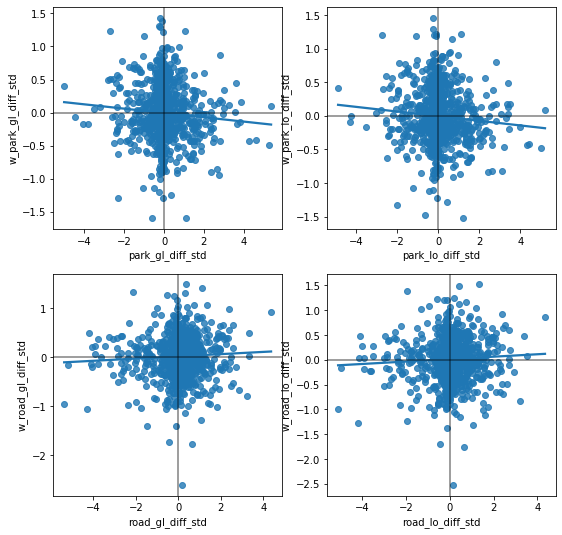

In [33]:
# Setup the figure and axis
f, axes = plt.subplots(2,2, figsize=(9, 9))
# Plot values
sns.regplot(x='park_gl_diff_std', y='w_park_gl_diff_std', data=gdf, ci=None, ax=axes[0][0])
axes[0][0].axvline(0, c='k', alpha=0.5)
axes[0][0].axhline(0, c='k', alpha=0.5)
sns.regplot(x='park_lo_diff_std', y='w_park_lo_diff_std', data=gdf, ci=None, ax=axes[0][1])
ax=axes[0][1].axvline(0, c='k', alpha=0.5)
ax=axes[0][1].axhline(0, c='k', alpha=0.5)
sns.regplot(x='road_gl_diff_std', y='w_road_gl_diff_std', data=gdf, ci=None, ax=axes[1][0])
ax=axes[1][0].axvline(0, c='k', alpha=0.5)
ax=axes[1][0].axhline(0, c='k', alpha=0.5)
sns.regplot(x='road_lo_diff_std', y='w_road_lo_diff_std', data=gdf, ci=None, ax=axes[1][1])
ax=axes[1][1].axvline(0, c='k', alpha=0.5)
ax=axes[1][1].axhline(0, c='k', alpha=0.5)
# Display
plt.show()

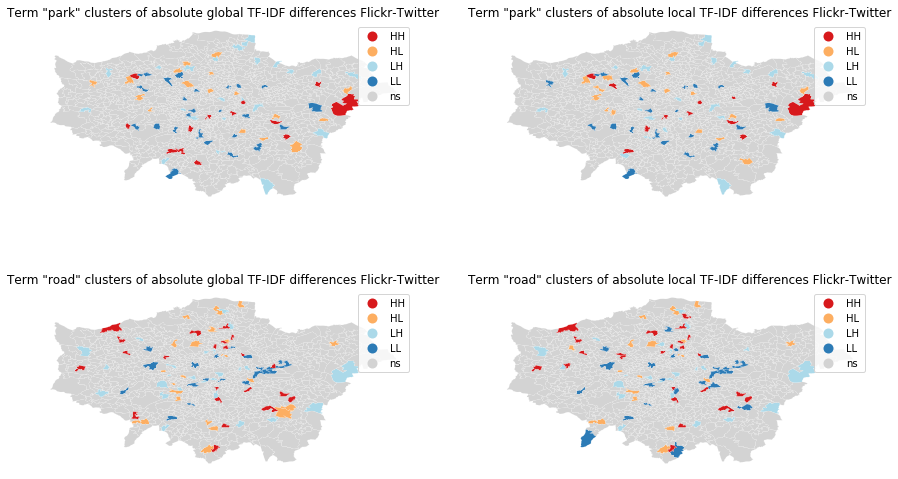

In [37]:
# Setup the figure and axis
f, axes = plt.subplots(2,2, figsize=(15, 9))

lmoran = ps.explore.esda.Moran_Local(gdf['park_gl_diff'], nW)
# Break observations into significant or not
gdf['park_gl_diff_signif'] = lmoran.p_sim < 0.05
# Store the quadrant they belong to
gdf['park_gl_diff_quadrant'] = lmoran.q
lisa_cluster(lmoran, gdf, ax=axes[0][0])
axes[0][0].set_title('Term "park" clusters of absolute global TF-IDF differences Flickr-Twitter')

lmoran = ps.explore.esda.Moran_Local(gdf['park_lo_diff'], nW)
# Break observations into significant or not
gdf['park_lo_diff_signif'] = lmoran.p_sim < 0.05
# Store the quadrant they belong to
gdf['park_lo_diff_quadrant'] = lmoran.q
lisa_cluster(lmoran, gdf, ax=axes[0][1])
axes[0][1].set_title('Term "park" clusters of absolute local TF-IDF differences Flickr-Twitter')

lmoran = ps.explore.esda.Moran_Local(gdf['road_gl_diff'], nW)
# Break observations into significant or not
gdf['road_gl_diff_signif'] = lmoran.p_sim < 0.05
# Store the quadrant they belong to
gdf['sentpos_tfidf_quadrant'] = lmoran.q
lisa_cluster(lmoran, gdf, ax=axes[1][0])
axes[1][0].set_title('Term "road" clusters of absolute global TF-IDF differences Flickr-Twitter')

lmoran = ps.explore.esda.Moran_Local(gdf['road_lo_diff'], nW)
# Break observations into significant or not
gdf['road_lo_diff_signif'] = lmoran.p_sim < 0.05
# Store the quadrant they belong to
gdf['road_lo_diff_quadrant'] = lmoran.q
lisa_cluster(lmoran, gdf, ax=axes[1][1])
axes[1][1].set_title('Term "road" clusters of absolute local TF-IDF differences Flickr-Twitter')

plt.show()

# Spatial distribution of sentiments

In [ ]:
# imports
import psycopg2
import pandas as pd
import geopandas as gpd
import geoplot.crs as gcrs
import geoplot as gplt
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
import numpy as np
import pysal as ps

## Spatial clusters of sentiments at ward level

In [2]:
# create data frame
sentiments_wards = pd.read_csv("sentiments_groups_wards.csv")
conn=psycopg2.connect("")
ward_poly = gpd.GeoDataFrame.from_postgis("select * from london_ward_citymerged_4326", conn, geom_col='geom' )
conn.close()

jwp = ward_poly.join(sentiments_wards.set_index('gss_code'), on='gss_code', how='inner')

# create spatial weights
jwp = jwp.rename(columns={"geom": "geometry"})
wards_w = ps.lib.weights.Queen.from_dataframe(jwp, idVariable='gss_code')
wards_w.transform = 'r'

# global Moran's I
gmoran = ps.explore.esda.Moran(jwp['sentiment'], wards_w)
print('sentiment: ', round(gmoran.I, 3), gmoran.p_sim)
gmoran = ps.explore.esda.Moran(jwp['sent_vader'], wards_w)
print('    VADER: ', round(gmoran.I, 3), gmoran.p_sim)
gmoran = ps.explore.esda.Moran(jwp['sentpos_tfidflr'], wards_w)
print('TF-IDF+LR: ', round(gmoran.I, 3), gmoran.p_sim)
gmoran = ps.explore.esda.Moran(jwp['shannon'], wards_w)
print('  Shannon: ', round(gmoran.I, 3), gmoran.p_sim)

sentiment:  0.014 0.224
    VADER:  0.066 0.007
TF-IDF+LR:  0.001 0.46
  Shannon:  0.129 0.001


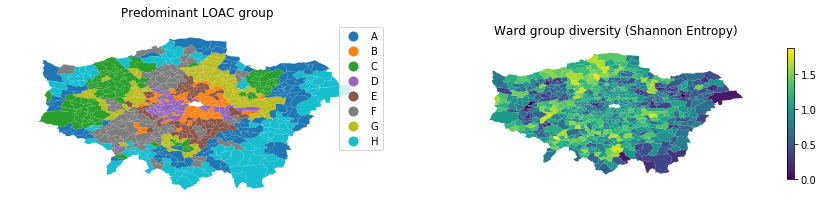

In [8]:
f, axes = plt.subplots(1,2, figsize=(15,8))
gplt.choropleth(jwp,
                ax=axes[0],
                cmap='tab10',
                hue='group',
                linewidth=0.0,
                legend=True)
axes[0].set_title('Predominant LOAC group')
gplt.choropleth(jwp,
                ax=axes[1],
                hue='shannon',
                linewidth=0.0,
                legend=True,
                legend_kwargs={'shrink': 0.3})
axes[1].set_title('Ward group diversity (Shannon Entropy)')
plt.show()

In [67]:
jwp['w_sentiment'] = ps.lib.weights.lag_spatial(wards_w, jwp['sentiment'])
jwp['sentiment_std'] = (jwp['sentiment'] - jwp['sentiment'].mean()) / jwp['sentiment'].std()
jwp['w_sentiment_std'] = ps.lib.weights.lag_spatial(wards_w, jwp['sentiment_std'])
jwp['w_sent_vader'] = ps.lib.weights.lag_spatial(wards_w, jwp['sent_vader'])
jwp['sent_vader_std'] = (jwp['sent_vader'] - jwp['sent_vader'].mean()) / jwp['sent_vader'].std()
jwp['w_sent_vader_std'] = ps.lib.weights.lag_spatial(wards_w, jwp['sent_vader_std'])
jwp['w_sentpos_tfidflr'] = ps.lib.weights.lag_spatial(wards_w, jwp['sentpos_tfidflr'])
jwp['sentpos_tfidflr_std'] = (jwp['sentpos_tfidflr'] - jwp['sentpos_tfidflr'].mean()) / jwp['sentpos_tfidflr'].std()
jwp['w_sentpos_tfidflr_std'] = ps.lib.weights.lag_spatial(wards_w, jwp['sentpos_tfidflr_std'])
jwp['w_shannon'] = ps.lib.weights.lag_spatial(wards_w, jwp['shannon'])
jwp['shannon_std'] = (jwp['shannon'] - jwp['shannon'].mean()) / jwp['shannon'].std()
jwp['w_shannon_std'] = ps.lib.weights.lag_spatial(wards_w, jwp['shannon_std'])
jwp[['gss_code', 'shannon', 'shannon_std', 'w_shannon', 'w_shannon_std']].head()

,gss_code,shannon,shannon_std,w_shannon,w_shannon_std
0,E05000405,0.804666,-0.457255,1.068669,0.273750
1,E05000414,1.479764,1.412044,1.262762,0.811181
2,E05000401,1.575460,1.677020,0.993031,0.064316
3,E05000400,1.164801,0.539934,0.888478,-0.225184
4,E05000402,1.406724,1.209800,1.097017,0.352245


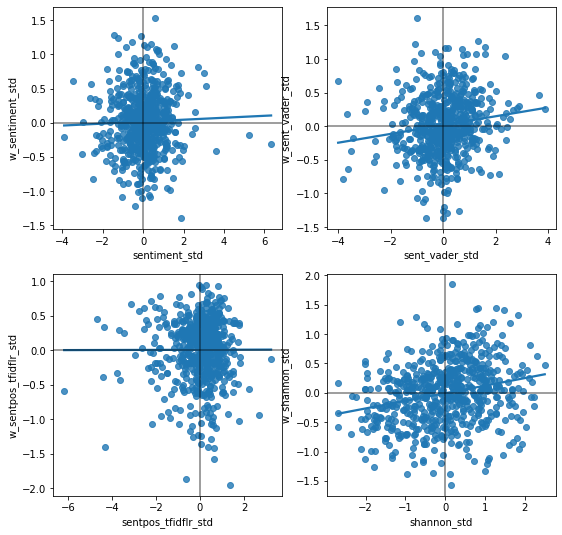

In [68]:
# Setup the figure and axis
f, axes = plt.subplots(2,2, figsize=(9, 9))
# Plot values
sns.regplot(x='sentiment_std', y='w_sentiment_std', data=jwp, ci=None, ax=axes[0][0])
axes[0][0].axvline(0, c='k', alpha=0.5)
axes[0][0].axhline(0, c='k', alpha=0.5)
sns.regplot(x='sent_vader_std', y='w_sent_vader_std', data=jwp, ci=None, ax=axes[0][1])
ax=axes[0][1].axvline(0, c='k', alpha=0.5)
ax=axes[0][1].axhline(0, c='k', alpha=0.5)
sns.regplot(x='sentpos_tfidflr_std', y='w_sentpos_tfidflr_std', data=jwp, ci=None, ax=axes[1][0])
ax=axes[1][0].axvline(0, c='k', alpha=0.5)
ax=axes[1][0].axhline(0, c='k', alpha=0.5)
sns.regplot(x='shannon_std', y='w_shannon_std', data=jwp, ci=None, ax=axes[1][1])
ax=axes[1][1].axvline(0, c='k', alpha=0.5)
ax=axes[1][1].axhline(0, c='k', alpha=0.5)
# Display
plt.show()

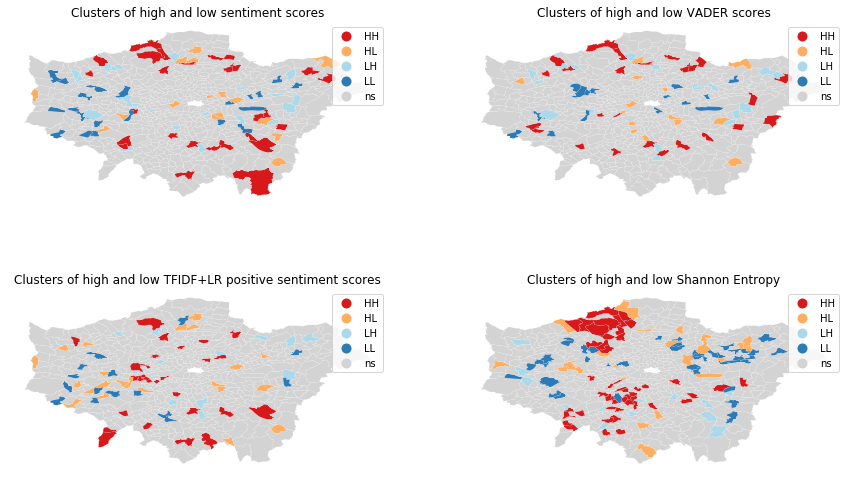

In [69]:
# Setup the figure and axis
f, axes = plt.subplots(2,2, figsize=(15, 9))

lmoran = pysal.explore.esda.Moran_Local(jwp['sentiment'], wards_w)
# Break observations into significant or not
jwp['sentiment_signif'] = lmoran.p_sim < 0.05
# Store the quadrant they belong to
jwp['sentiment_quadrant'] = lmoran.q
lisa_cluster(lmoran, jwp, ax=axes[0][0])
axes[0][0].set_title('Clusters of high and low sentiment scores')

lmoran = pysal.explore.esda.Moran_Local(jwp['sent_vader'], wards_w)
# Break observations into significant or not
jwp['sent_vader_signif'] = lmoran.p_sim < 0.05
# Store the quadrant they belong to
jwp['sent_vader_quadrant'] = lmoran.q
lisa_cluster(lmoran, jwp, ax=axes[0][1])
axes[0][1].set_title('Clusters of high and low VADER scores')

lmoran = pysal.explore.esda.Moran_Local(jwp['sentpos_tfidflr'], wards_w)
# Break observations into significant or not
jwp['sentpos_tfidflr_signif'] = lmoran.p_sim < 0.05
# Store the quadrant they belong to
jwp['sentpos_tfidf_quadrant'] = lmoran.q
lisa_cluster(lmoran, jwp, ax=axes[1][0])
axes[1][0].set_title('Clusters of high and low TFIDF+LR positive sentiment scores')

lmoran = pysal.explore.esda.Moran_Local(jwp['shannon'], wards_w)
# Break observations into significant or not
jwp['shannon_signif'] = lmoran.p_sim < 0.05
# Store the quadrant they belong to
jwp['shannon_quadrant'] = lmoran.q
lisa_cluster(lmoran, jwp, ax=axes[1][1])
axes[1][1].set_title('Clusters of high and low Shannon Entropy')

plt.show()

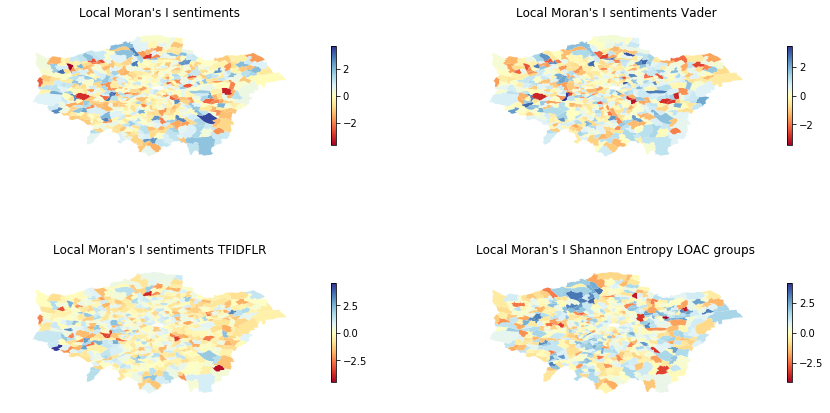

In [70]:
# compute and plot z_score Local Moran'I of sentiments and group entropy
fig, axarr = plt.subplots(2, 2, figsize=(15, 8))

lmoran = ps.explore.esda.Moran_Local(jwp['sentiment'], wards_w)
lmoran_z = pd.DataFrame(data=lmoran.z_sim)
jwp['sent_lmoran_z'] = lmoran_z.values
max_lmoran_z = max(abs(jwp['sent_lmoran_z']))
gplt.choropleth(jwp,
                ax=axarr[0][0],
                hue='sent_lmoran_z',
                cmap='RdYlBu',
                linewidth=0.0,
                norm=colors.Normalize(vmin=-max_lmoran_z, vmax=max_lmoran_z),
                legend=True,
                legend_kwargs={'shrink': 0.5})
axarr[0][0].set_title("Local Moran's I sentiments")

lmoran = ps.explore.esda.Moran_Local(jwp['sent_vader'], wards_w)
lmoran_z = pd.DataFrame(data=lmoran.z_sim)
jwp['sentVader_lmoran_z'] = lmoran_z.values
max_lmoran_z = max(abs(jwp['sentVader_lmoran_z']))
gplt.choropleth(jwp,
                ax=axarr[0][1],
                hue='sentVader_lmoran_z',
                cmap='RdYlBu',
                linewidth=0.0,
                norm=colors.Normalize(vmin=-max_lmoran_z, vmax=max_lmoran_z),
                legend=True,
                legend_kwargs={'shrink': 0.5})
axarr[0][1].set_title("Local Moran's I sentiments Vader")

lmoran = ps.explore.esda.Moran_Local(jwp['sentpos_tfidflr'], wards_w)
lmoran_z = pd.DataFrame(data=lmoran.z_sim)
jwp['sentTFIDFLR_lmoran_z'] = lmoran_z.values
max_lmoran_z = max(abs(jwp['sentTFIDFLR_lmoran_z']))
gplt.choropleth(jwp,
                ax=axarr[1][0],
                hue='sentTFIDFLR_lmoran_z',
                cmap='RdYlBu',
                linewidth=0.0,
                norm=colors.Normalize(vmin=-max_lmoran_z, vmax=max_lmoran_z),
                legend=True,
                legend_kwargs={'shrink': 0.5})
axarr[1][0].set_title("Local Moran's I sentiments TFIDFLR")
                               
lmoran = ps.explore.esda.Moran_Local(jwp['shannon'], wards_w)
lmoran_z = pd.DataFrame(data=lmoran.z_sim)
jwp['shannon_lmoran_z'] = lmoran_z.values
max_lmoran_z = max(abs(jwp['shannon_lmoran_z']))
gplt.choropleth(jwp,
                ax=axarr[1][1],
                hue='shannon_lmoran_z',
                cmap='RdYlBu',
                linewidth=0.0,
                norm=colors.Normalize(vmin=-max_lmoran_z, vmax=max_lmoran_z),
                legend=True,
                legend_kwargs={'shrink': 0.5})
axarr[1][1].set_title("Local Moran's I Shannon Entropy LOAC groups")

plt.show()

## Spatial clusters of sentiments at MSOA level and comparison with wards

sentiment:  0.011 0.23


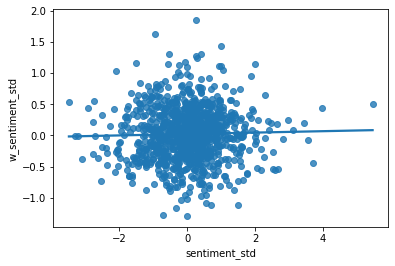

In [71]:
# create data frame
sentiments_msoa = pd.read_csv("sentiments_sociodem_msoa.csv")
conn=psycopg2.connect("")
msoa_poly = gpd.GeoDataFrame.from_postgis("select * from london_msoa_2011_gen_4326", conn, geom_col='geom')
conn.close()

jmp = msoa_poly.join(sentiments_msoa.set_index('code'), on='code', how='inner')

# create spatial weights
jmp = jmp.rename(columns={"geom": "geometry"})
msoa_w = ps.lib.weights.Queen.from_dataframe(jmp, idVariable='code')
msoa_w.transform = 'r'

# global Moran's I
gmoran = ps.explore.esda.Moran(jmp['sentiment'], msoa_w)
print('sentiment: ', round(gmoran.I, 3), gmoran.p_sim)

jmp['w_sentiment'] = ps.lib.weights.lag_spatial(msoa_w, jmp['sentiment'])
jmp['sentiment_std'] = (jmp['sentiment'] - jmp['sentiment'].mean()) / jmp['sentiment'].std()
jmp['w_sentiment_std'] = ps.lib.weights.lag_spatial(msoa_w, jmp['sentiment_std'])

# Setup the figure and axis
# Plot values
sns.regplot(x='sentiment_std', y='w_sentiment_std', data=jmp, ci=None)
# Display
plt.show()

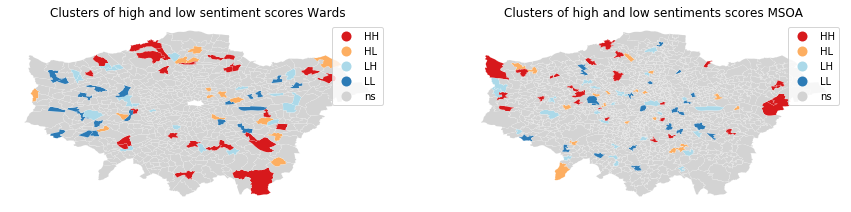

In [72]:
# Setup the figure and axis
f, axes = plt.subplots(1,2, figsize=(15, 6))

lmoran = ps.explore.esda.Moran_Local(jwp['sentiment'], wards_w)
# Break observations into significant or not
jwp['sentiment_signif'] = lmoran.p_sim < 0.05
# Store the quadrant they belong to
jwp['sentiment_quadrant'] = lmoran.q
lisa_cluster(lmoran, jwp, ax=axes[0])
axes[0].set_title('Clusters of high and low sentiment scores Wards')

lmoran = ps.explore.esda.Moran_Local(jmp['sentiment'], msoa_w)
# Break observations into significant or not
jmp['sentiment_signif'] = lmoran.p_sim < 0.05
# Store the quadrant they belong to
jmp['sentiment_quadrant'] = lmoran.q
lisa_cluster(lmoran, jmp, ax=axes[1])
axes[1].set_title('Clusters of high and low sentiments scores MSOA')

plt.show()

# Changes over time

In [ ]:
# imports
import psycopg2
import pandas as pd
import geopandas as gpd
import geoplot.crs as gcrs
import geoplot as gplt
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
import numpy as np
import pysal as ps
from scipy.stats import entropy

## Changes at ward level

In [3]:
# calculate changes
conn=psycopg2.connect("")
ward_poly = gpd.GeoDataFrame.from_postgis("select * from london_ward_citymerged_4326", conn, geom_col='geom' )
cur = conn.cursor()

#
# Y1
#
cur.execute("select ward2011code, AVG(sentiment), AVG(sent_vader), AVG(sentpos_tfidflr), COUNT(*), COUNT(*) filter (where sentiment=0) from london_twitter where ward2011code is not null and sentiment is not null and tw_cr_tstz >= '2017-10-01 00:00:00' and tw_cr_tstz <= '2018-05-31 23:59:59'group by ward2011code")
avg_ward_sents = cur.fetchall()

avg_ward_sents = pd.DataFrame(avg_ward_sents, columns=["code","sentiment_Y1","sent_vader_Y1", "sentpos_tfidflr_Y1","tw_count_Y1", "tw_neg_count_Y1"])
avg_ward_sents = avg_ward_sents.astype({"code": str, "sentiment_Y1": float, "sent_vader_Y1": float, "sentpos_tfidflr_Y1": float,"tw_count_Y1": int,"tw_neg_count_Y1": int})
jwp = ward_poly.join(avg_ward_sents.set_index('code'), on='gss_code', how='inner')

jwp['tw_neg_ratio_Y1'] = jwp['tw_neg_count_Y1'] / jwp['tw_count_Y1']

#
# Y2
#
cur.execute("select ward2011code, AVG(sentiment), AVG(sent_vader), AVG(sentpos_tfidflr), COUNT(*), COUNT(*) filter (where sentiment=0) from london_twitter where ward2011code is not null and sentiment is not null and tw_cr_tstz >= '2018-10-01 00:00:00' and tw_cr_tstz <= '2019-05-31 23:59:59'group by ward2011code")
avg_ward_sents = cur.fetchall()

avg_ward_sents = pd.DataFrame(avg_ward_sents, columns=["code","sentiment_Y2","sent_vader_Y2", "sentpos_tfidflr_Y2","tw_count_Y2", "tw_neg_count_Y2"])
avg_ward_sents = avg_ward_sents.astype({"code": str, "sentiment_Y2": float, "sent_vader_Y2": float, "sentpos_tfidflr_Y2": float,"tw_count_Y2": int,"tw_neg_count_Y2": int})
jwp = jwp.join(avg_ward_sents.set_index('code'), on='gss_code', how='inner')

jwp['tw_neg_ratio_Y2'] = jwp['tw_neg_count_Y2'] / jwp['tw_count_Y2']

#
# Y3
#
cur.execute("select ward2011code, AVG(sentiment), AVG(sent_vader), AVG(sentpos_tfidflr), COUNT(*), COUNT(*) filter (where sentiment=0) from london_twitter where ward2011code is not null and sentiment is not null and tw_cr_tstz >= '2019-10-01 00:00:00' and tw_cr_tstz <= '2020-05-31 23:59:59'group by ward2011code")
avg_ward_sents = cur.fetchall()

avg_ward_sents = pd.DataFrame(avg_ward_sents, columns=["code","sentiment_Y3","sent_vader_Y3", "sentpos_tfidflr_Y3","tw_count_Y3", "tw_neg_count_Y3"])
avg_ward_sents = avg_ward_sents.astype({"code": str, "sentiment_Y3": float, "sent_vader_Y3": float, "sentpos_tfidflr_Y3": float,"tw_count_Y3": int,"tw_neg_count_Y3": int})
jwp = jwp.join(avg_ward_sents.set_index('code'), on='gss_code', how='inner')

jwp['tw_neg_ratio_Y3'] = jwp['tw_neg_count_Y3'] / jwp['tw_count_Y3']

conn.close()

# calculate percentage changes between years
jwp['sent_Y1-2'] = (jwp['sentiment_Y2'] - jwp['sentiment_Y1']) / jwp['sentiment_Y1'] * 100
jwp['sent_Y2-3'] = (jwp['sentiment_Y3'] - jwp['sentiment_Y2']) / jwp['sentiment_Y2'] * 100
jwp['sent_Y1-3'] = (jwp['sentiment_Y3'] - jwp['sentiment_Y1']) / jwp['sentiment_Y1'] * 100
jwp['tnr_Y1-2'] = ((jwp['tw_neg_ratio_Y2'] - jwp['tw_neg_ratio_Y1']) / jwp['tw_neg_ratio_Y1']).fillna(0).replace([np.inf, -np.inf], 0)
jwp['tnr_Y2-3'] = ((jwp['tw_neg_ratio_Y3'] - jwp['tw_neg_ratio_Y2']) / jwp['tw_neg_ratio_Y2']).fillna(0).replace([np.inf, -np.inf], 0)
jwp['tnr_Y1-3'] = ((jwp['tw_neg_ratio_Y3'] - jwp['tw_neg_ratio_Y1']) / jwp['tw_neg_ratio_Y1']).fillna(0).replace([np.inf, -np.inf], 0)

# filter out MSOA with few tweets
fjwp = jwp[(jwp['tw_count_Y1']>10) & (jwp['tw_count_Y2']>10) & (jwp['tw_count_Y3']>10) & (jwp['tw_neg_count_Y1']>0) & (jwp['tw_neg_count_Y2']>0) & (jwp['tw_neg_count_Y3']>0)]
fjwp.describe()

,gid,hectares,nonld_area,poly_id,sentiment_Y1,sent_vader_Y1,sentpos_tfidflr_Y1,tw_count_Y1,tw_neg_count_Y1,tw_neg_ratio_Y1,...,sentpos_tfidflr_Y3,tw_count_Y3,tw_neg_count_Y3,tw_neg_ratio_Y3,sent_Y1-2,sent_Y2-3,sent_Y1-3,tnr_Y1-2,tnr_Y2-3,tnr_Y1-3
count,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,...,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,337.139860,240.916988,3.659110,87146.531469,1.144744,0.261236,0.734595,2207.694639,28.452214,0.017762,...,0.751708,1065.857809,13.041958,0.016594,4.320152,0.207139,4.424907,0.088372,0.624960,0.241888
std,177.328485,252.836389,14.587821,33072.718866,0.052261,0.060701,0.036483,14136.313120,151.754261,0.014077,...,0.037358,6084.250642,66.646179,0.017914,5.505991,5.780841,6.592456,1.108562,2.808019,1.417878
min,1.000000,39.212000,0.000000,50450.000000,1.000000,0.015978,0.550944,19.000000,1.000000,0.001658,...,0.538994,26.000000,1.000000,0.002242,-15.789474,-25.937882,-23.307101,-0.958442,-0.924518,-0.961292
25%,199.000000,110.305000,0.000000,50825.000000,1.113074,0.229395,0.719605,311.000000,4.000000,0.010278,...,0.735938,177.000000,2.000000,0.008197,1.237711,-3.039514,1.097715,-0.450839,-0.288949,-0.441341
50%,348.000000,177.463000,0.000000,116789.000000,1.147702,0.262940,0.741895,596.000000,9.000000,0.014101,...,0.758416,331.000000,4.000000,0.012500,4.147389,0.139644,4.266412,-0.196096,0.095819,-0.087719
75%,494.000000,276.497000,0.000000,117264.000000,1.173913,0.295544,0.758316,1294.000000,19.000000,0.019651,...,0.775158,703.000000,9.000000,0.019208,7.066684,3.301911,7.770968,0.235609,0.745211,0.362245
max,625.000000,2903.960000,142.283000,123573.000000,1.315789,0.448822,0.811201,283192.000000,3031.000000,0.129032,...,0.837399,117600.000000,1273.000000,0.224138,24.455070,22.322395,27.014218,11.909091,49.655172,13.428571


In [10]:
jwp[['tw_count_Y1', 'tw_count_Y2', 'tw_count_Y3', 'sentiment_Y1', 'sentiment_Y2', 'sentiment_Y3', 'sent_Y1-2', 'sent_Y2-3', 'sent_Y1-3', 'tnr_Y1-3']].describe()

,tw_count_Y1,tw_count_Y2,tw_count_Y3,sentiment_Y1,sentiment_Y2,sentiment_Y3,sent_Y1-2,sent_Y2-3,sent_Y1-3,tnr_Y1-3
count,625.000000,625.000000,625.00000,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000
mean,1577.345600,1191.259200,759.91840,1.146481,1.196684,1.196522,4.539723,0.233763,4.574041,0.090790
std,11746.133092,9405.588583,5059.49611,0.063355,0.077587,0.081028,6.893751,7.276555,7.806600,1.535745
min,12.000000,8.000000,5.00000,0.944444,0.909091,0.900000,-25.000000,-25.937882,-26.846101,-1.000000
25%,157.000000,128.000000,89.00000,1.110092,1.152174,1.147929,0.768755,-3.417552,0.516331,-0.632022
50%,377.000000,298.000000,207.00000,1.146670,1.197292,1.199557,4.251949,0.137862,4.266412,-0.162617
75%,920.000000,658.000000,501.00000,1.179487,1.243243,1.241026,7.816357,4.062500,8.506616,0.142667
max,283192.000000,228666.000000,117600.00000,1.625000,1.528090,1.565789,32.258065,38.461538,37.837838,13.428571


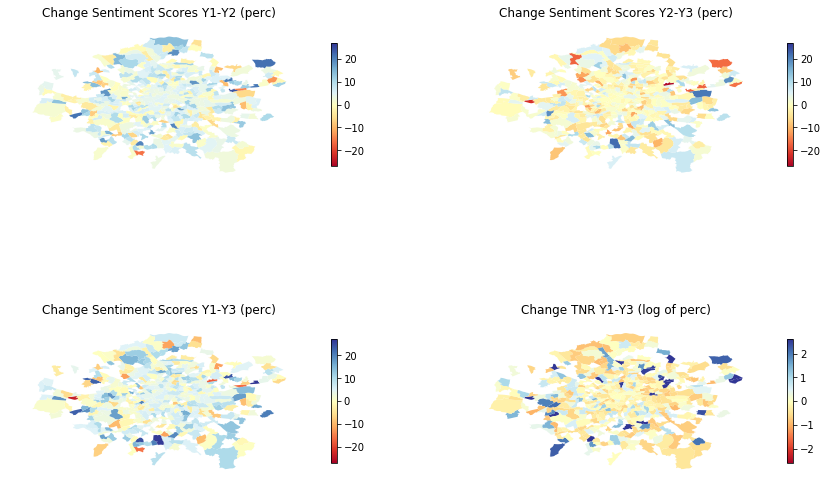

In [100]:
# plot differences in sentiments over the years.
fig, axarr = plt.subplots(2, 2, figsize=(15, 10))

max_value = abs(max([max(fjwp['sent_Y1-2']), max(fjwp['sent_Y2-3']), max(fjwp['sent_Y1-3'])]))
gplt.choropleth(fjwp,
                ax=axarr[0][0],
                hue='sent_Y1-2',
                cmap='RdYlBu',
                norm=colors.Normalize(vmin=-max_value, vmax=max_value),
                legend=True,
                linewidth=0.0,
                legend_kwargs={'shrink': 0.5})
axarr[0][0].set_title("Change Sentiment Scores Y1-Y2 (perc)")

gplt.choropleth(fjwp,
                ax=axarr[0][1],
                hue='sent_Y2-3',
                cmap='RdYlBu',
                linewidth=0.0,
                norm=colors.Normalize(vmin=-max_value, vmax=max_value),
                legend=True,
                legend_kwargs={'shrink': 0.5})
axarr[0][1].set_title("Change Sentiment Scores Y2-Y3 (perc)")

gplt.choropleth(fjwp,
                ax=axarr[1][0],
                hue='sent_Y1-3',
                cmap='RdYlBu',
                linewidth=0.0,
                norm=colors.Normalize(vmin=-max_value, vmax=max_value),
                legend=True,
                legend_kwargs={'shrink': 0.5})
axarr[1][0].set_title("Change Sentiment Scores Y1-Y3 (perc)")
                               
max_value = abs(max(fjwp['tnr_Y1-3'], key=abs))
gplt.choropleth(fjwp,
                ax=axarr[1][1],
                hue='tnr_Y1-3',
                cmap='RdYlBu',
                linewidth=0.0,
                norm=colors.Normalize(vmin=-np.log(max_value), vmax=np.log(max_value)),
                legend=True,
                legend_kwargs={'shrink': 0.5})
axarr[1][1].set_title("Change TNR Y1-Y3 (log of perc)")

plt.show()

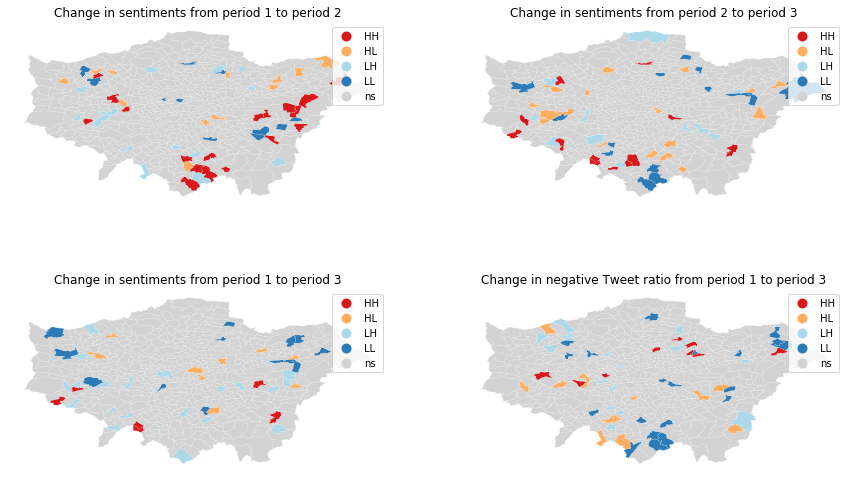

In [101]:
# spatial clustes of change

# create spatial weights
jwp = jwp.rename(columns={"geom": "geometry"})
wards_w = pysal.lib.weights.Queen.from_dataframe(jwp, idVariable='gss_code')
wards_w.transform = 'r'

# Setup the figure and axis
f, axes = plt.subplots(2,2, figsize=(15, 9))

lmoran = ps.explore.esda.Moran_Local(jwp['sent_Y1-2'], wards_w)
# Break observations into significant or not
jwp['sent_Y1-2_signif'] = lmoran.p_sim < 0.05
# Store the quadrant they belong to
jwp['sent_Y1-2_quadrant'] = lmoran.q
lisa_cluster(lmoran, jwp, ax=axes[0][0])
axes[0][0].set_title('Change in sentiments from period 1 to period 2')

lmoran = ps.explore.esda.Moran_Local(jwp['sent_Y2-3'], wards_w)
# Break observations into significant or not
jwp['sent_Y2-3_signif'] = lmoran.p_sim < 0.05
# Store the quadrant they belong to
jwp['sent_Y2-3_quadrant'] = lmoran.q
lisa_cluster(lmoran, jwp, ax=axes[0][1])
axes[0][1].set_title('Change in sentiments from period 2 to period 3')

lmoran = ps.explore.esda.Moran_Local(jwp['sent_Y1-3'], wards_w)
# Break observations into significant or not
jwp['sent_Y1-3_signif'] = lmoran.p_sim < 0.05
# Store the quadrant they belong to
jwp['sent_Y1-3_quadrant'] = lmoran.q
lisa_cluster(lmoran, jwp, ax=axes[1][0])
axes[1][0].set_title('Change in sentiments from period 1 to period 3')

lmoran = ps.explore.esda.Moran_Local(jwp['tnr_Y1-3'], wards_w)
# Break observations into significant or not
jwp['tnr_Y1-3'] = lmoran.p_sim < 0.05
# Store the quadrant they belong to
jwp['tnr_Y1-3'] = lmoran.q
lisa_cluster(lmoran, jwp, ax=axes[1][1])
axes[1][1].set_title('Change in negative Tweet ratio from period 1 to period 3')

plt.show()

## Changes at MSOA level

In [102]:
conn=psycopg2.connect("")
msoa_poly = gpd.GeoDataFrame.from_postgis("select * from london_msoa_2011_gen_4326", conn, geom_col='geom' )
cur = conn.cursor()

#
# Y1
#
cur.execute("select msoa2011code, AVG(sentiment), AVG(sent_vader), AVG(sentpos_tfidflr), COUNT(*), COUNT(*) filter (where sentiment=0) from london_twitter where msoa2011code is not null and sentiment is not null and tw_cr_tstz >= '2017-10-01 00:00:00' and tw_cr_tstz <= '2018-05-31 23:59:59'group by msoa2011code")
avg_msoa_sents = cur.fetchall()

avg_msoa_sents = pd.DataFrame(avg_msoa_sents, columns=["code","sentiment_Y1","sent_vader_Y1", "sentpos_tfidflr_Y1","tw_count_Y1", "tw_neg_count_Y1"])
avg_msoa_sents = avg_msoa_sents.astype({"code": str, "sentiment_Y1": float, "sent_vader_Y1": float, "sentpos_tfidflr_Y1": float,"tw_count_Y1": int,"tw_neg_count_Y1": int})
jmp = msoa_poly.join(avg_msoa_sents.set_index('code'), on='code', how='inner')

jmp['tw_neg_ratio_Y1'] = jmp['tw_neg_count_Y1'] / jmp['tw_count_Y1']

#
# Y2
#
cur.execute("select msoa2011code, AVG(sentiment), AVG(sent_vader), AVG(sentpos_tfidflr), COUNT(*), COUNT(*) filter (where sentiment=0) from london_twitter where msoa2011code is not null and sentiment is not null and tw_cr_tstz >= '2018-10-01 00:00:00' and tw_cr_tstz <= '2019-05-31 23:59:59'group by msoa2011code")
avg_msoa_sents = cur.fetchall()

avg_msoa_sents = pd.DataFrame(avg_msoa_sents, columns=["code","sentiment_Y2","sent_vader_Y2", "sentpos_tfidflr_Y2","tw_count_Y2", "tw_neg_count_Y2"])
avg_msoa_sents = avg_msoa_sents.astype({"code": str, "sentiment_Y2": float, "sent_vader_Y2": float, "sentpos_tfidflr_Y2": float,"tw_count_Y2": int,"tw_neg_count_Y2": int})
jmp = jmp.join(avg_msoa_sents.set_index('code'), on='code', how='inner')

jmp['tw_neg_ratio_Y2'] = jmp['tw_neg_count_Y2'] / jmp['tw_count_Y2']

#
# Y3
#
cur.execute("select msoa2011code, AVG(sentiment), AVG(sent_vader), AVG(sentpos_tfidflr), COUNT(*), COUNT(*) filter (where sentiment=0) from london_twitter where msoa2011code is not null and sentiment is not null and tw_cr_tstz >= '2019-10-01 00:00:00' and tw_cr_tstz <= '2020-05-31 23:59:59'group by msoa2011code")
avg_msoa_sents = cur.fetchall()

avg_msoa_sents = pd.DataFrame(avg_msoa_sents, columns=["code","sentiment_Y3","sent_vader_Y3", "sentpos_tfidflr_Y3","tw_count_Y3", "tw_neg_count_Y3"])
avg_msoa_sents = avg_msoa_sents.astype({"code": str, "sentiment_Y3": float, "sent_vader_Y3": float, "sentpos_tfidflr_Y3": float,"tw_count_Y3": int,"tw_neg_count_Y3": int})
jmp = jmp.join(avg_msoa_sents.set_index('code'), on='code', how='inner')

jmp['tw_neg_ratio_Y3'] = jmp['tw_neg_count_Y3'] / jmp['tw_count_Y3']

conn.close()

# calculate percentage changes between years
jmp['sent_Y1-2'] = (jmp['sentiment_Y2'] - jmp['sentiment_Y1']) / jmp['sentiment_Y1'] * 100
jmp['sent_Y2-3'] = (jmp['sentiment_Y3'] - jmp['sentiment_Y2']) / jmp['sentiment_Y2'] * 100
jmp['sent_Y1-3'] = (jmp['sentiment_Y3'] - jmp['sentiment_Y1']) / jmp['sentiment_Y1'] * 100
jmp['tnr_Y1-2'] = ((jmp['tw_neg_ratio_Y2'] - jmp['tw_neg_ratio_Y1']) / jmp['tw_neg_ratio_Y1']).fillna(0).replace([np.inf, -np.inf], 0)
jmp['tnr_Y2-3'] = ((jmp['tw_neg_ratio_Y3'] - jmp['tw_neg_ratio_Y2']) / jmp['tw_neg_ratio_Y2']).fillna(0).replace([np.inf, -np.inf], 0)
jmp['tnr_Y1-3'] = ((jmp['tw_neg_ratio_Y3'] - jmp['tw_neg_ratio_Y1']) / jmp['tw_neg_ratio_Y1']).fillna(0).replace([np.inf, -np.inf], 0)

# filter out MSOA with few tweets
fjmp = jmp[(jmp['tw_count_Y1']>10) & (jmp['tw_count_Y2']>10) & (jmp['tw_count_Y3']>10) & (jmp['tw_neg_count_Y1']>0) & (jmp['tw_neg_count_Y2']>0) & (jmp['tw_neg_count_Y3']>0)]
fjmp.describe()


,gid,sentiment_Y1,sent_vader_Y1,sentpos_tfidflr_Y1,tw_count_Y1,tw_neg_count_Y1,tw_neg_ratio_Y1,sentiment_Y2,sent_vader_Y2,sentpos_tfidflr_Y2,...,sentpos_tfidflr_Y3,tw_count_Y3,tw_neg_count_Y3,tw_neg_ratio_Y3,sent_Y1-2,sent_Y2-3,sent_Y1-3,tnr_Y1-2,tnr_Y2-3,tnr_Y1-3
count,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,...,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000
mean,529.295547,1.144304,0.262199,0.734674,1852.222672,23.706478,0.018610,1.192700,0.353873,0.751712,...,0.748913,874.777328,10.842105,0.019406,4.288176,0.036406,4.169851,0.170556,0.662311,0.437221
std,280.666762,0.052773,0.063302,0.038637,12951.917221,136.423265,0.016071,0.074895,0.094411,0.043454,...,0.045433,5567.304664,58.407877,0.031064,5.686271,7.168162,7.368328,1.195351,2.337905,2.126424
min,1.000000,0.969325,0.020130,0.542227,12.000000,1.000000,0.001443,0.923077,-0.022216,0.532541,...,0.386332,11.000000,1.000000,0.001761,-20.879121,-54.475309,-54.627216,-0.968085,-0.924330,-0.898541
25%,298.000000,1.113461,0.230691,0.718323,227.250000,3.000000,0.009920,1.152021,0.309289,0.735747,...,0.730998,131.000000,2.000000,0.008342,1.442717,-3.416412,0.342213,-0.452015,-0.303289,-0.439881
50%,552.000000,1.146603,0.260634,0.742556,466.000000,7.000000,0.013850,1.197342,0.358739,0.761185,...,0.757178,257.500000,3.000000,0.013119,4.254812,0.046200,3.912700,-0.175055,0.094003,-0.055872
75%,778.500000,1.175193,0.297213,0.759625,1112.750000,16.000000,0.020603,1.237285,0.404275,0.777051,...,0.776931,556.500000,8.000000,0.021277,7.128589,3.021482,8.028679,0.344255,0.835991,0.505975
max,983.000000,1.365385,0.507947,0.826487,279820.000000,2922.000000,0.122159,1.520492,0.696200,0.858493,...,0.830743,115898.000000,1184.000000,0.571429,26.626016,36.111111,31.410256,10.280000,39.000000,32.714286


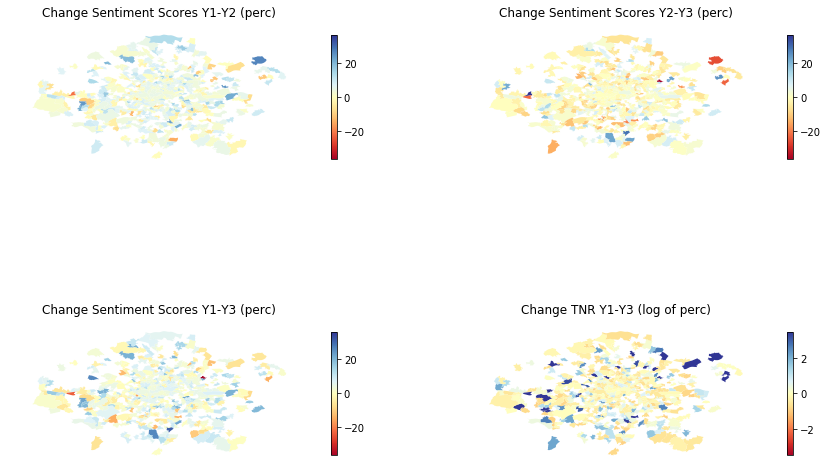

In [103]:
# plot differences in sentiments over the years.
fig, axarr = plt.subplots(2, 2, figsize=(15, 10))

max_value = abs(max([max(fjmp['sent_Y1-2']), max(fjmp['sent_Y2-3']), max(fjmp['sent_Y1-3'])]))
gplt.choropleth(fjmp,
                ax=axarr[0][0],
                hue='sent_Y1-2',
                cmap='RdYlBu',
                norm=colors.Normalize(vmin=-max_value, vmax=max_value),
                legend=True,
                linewidth=0.0,
                legend_kwargs={'shrink': 0.5})
axarr[0][0].set_title("Change Sentiment Scores Y1-Y2 (perc)")

gplt.choropleth(fjmp,
                ax=axarr[0][1],
                hue='sent_Y2-3',
                cmap='RdYlBu',
                linewidth=0.0,
                norm=colors.Normalize(vmin=-max_value, vmax=max_value),
                legend=True,
                legend_kwargs={'shrink': 0.5})
axarr[0][1].set_title("Change Sentiment Scores Y2-Y3 (perc)")

gplt.choropleth(fjmp,
                ax=axarr[1][0],
                hue='sent_Y1-3',
                cmap='RdYlBu',
                linewidth=0.0,
                norm=colors.Normalize(vmin=-max_value, vmax=max_value),
                legend=True,
                legend_kwargs={'shrink': 0.5})
axarr[1][0].set_title("Change Sentiment Scores Y1-Y3 (perc)")
                               
max_value = abs(max(fjmp['tnr_Y1-3'], key=abs))
gplt.choropleth(fjmp,
                ax=axarr[1][1],
                hue='tnr_Y1-3',
                cmap='RdYlBu',
                linewidth=0.0,
                norm=colors.Normalize(vmin=-np.log(max_value), vmax=np.log(max_value)),
                legend=True,
                legend_kwargs={'shrink': 0.5})
axarr[1][1].set_title("Change TNR Y1-Y3 (log of perc)")

plt.show()

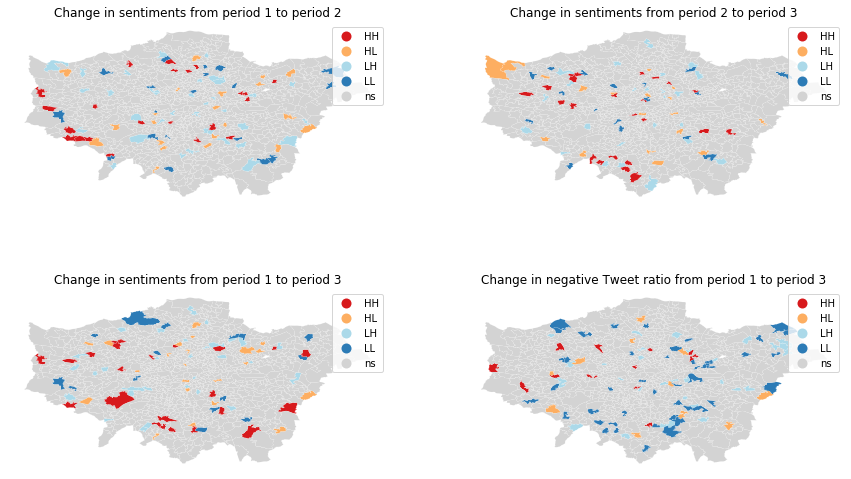

In [104]:
# spatial clusters of change

# create spatial weights
jmp = jmp.rename(columns={"geom": "geometry"})
msoas_w = ps.lib.weights.Queen.from_dataframe(jmp, idVariable='code')
msoas_w.transform = 'r'

# Setup the figure and axis
f, axes = plt.subplots(2,2, figsize=(15, 9))

lmoran = ps.explore.esda.Moran_Local(jmp['sent_Y1-2'], msoas_w)
# Break observations into significant or not
jmp['sent_Y1-2_signif'] = lmoran.p_sim < 0.05
# Store the quadrant they belong to
jmp['sent_Y1-2_quadrant'] = lmoran.q
lisa_cluster(lmoran, jmp, ax=axes[0][0])
axes[0][0].set_title('Change in sentiments from period 1 to period 2')

lmoran = ps.explore.esda.Moran_Local(jmp['sent_Y2-3'], msoas_w)
# Break observations into significant or not
jmp['sent_Y2-3_signif'] = lmoran.p_sim < 0.05
# Store the quadrant they belong to
jmp['sent_Y2-3_quadrant'] = lmoran.q
lisa_cluster(lmoran, jmp, ax=axes[0][1])
axes[0][1].set_title('Change in sentiments from period 2 to period 3')

lmoran = ps.explore.esda.Moran_Local(jmp['sent_Y1-3'], msoas_w)
# Break observations into significant or not
jmp['sent_Y1-3_signif'] = lmoran.p_sim < 0.05
# Store the quadrant they belong to
jmp['sent_Y1-3_quadrant'] = lmoran.q
lisa_cluster(lmoran, jmp, ax=axes[1][0])
axes[1][0].set_title('Change in sentiments from period 1 to period 3')

lmoran = ps.explore.esda.Moran_Local(jmp['tnr_Y1-3'], msoas_w)
# Break observations into significant or not
jmp['tnr_Y1-3'] = lmoran.p_sim < 0.05
# Store the quadrant they belong to
jmp['tnr_Y1-3'] = lmoran.q
lisa_cluster(lmoran, jmp, ax=axes[1][1])
axes[1][1].set_title('Change in negative Tweet ratio from period 1 to period 3')

plt.show()